REGRESSOR CNN

In [ ]:
import os
import tensorflow as tf

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Configurazione manuale (più sicura)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("MEmory Growth attivata su GPU")
    except RuntimeError as e:
        print(e)

        
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pyplot as plt
import pandas as pd
import cv2 
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import mean_absolute_error
import gc

try:
    tf.config.experimental.enable_op_determinism()
    print("Op Determinism Abilitato!")
except AttributeError:
    print("Attenzione: La tua versione di TF è troppo vecchia per enable_op_determinism.")

def reset_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
SEEDS = [42,555]

MEmory Growth attivata su GPU
2.21.0-dev20251210
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Op Determinism Abilitato!


DATASET LOADING

In [10]:
def load_dataset():
    folder='dataset/images'
    data=[]
    for filename in sorted(os.listdir(folder)):   
        img_path=os.path.join(folder,filename)
        img=cv2.imread(img_path) #opencv save in bgr
        data.append({
            'image':img,
            'filename':filename
        })

    data_map = {item['filename']: item['image'] for item in data}
    label=pd.read_csv('dataset/raw/bbx_annotations.csv')
    #just to avoid warning
    coords = ['xmin', 'xmax', 'ymin', 'ymax']
    label[coords] = label[coords].astype(float)
    
    upper_mask = label['filename'].str.lower().str.contains('upper')
    label.loc[upper_mask, ['xmin', 'xmax', 'ymin', 'ymax']] /= 2
    
    for i,item in enumerate(data):
        if "upper" in item["filename"].lower():
            data[i]['image']=cv2.resize(
                data[i]['image'],
                (data[i]['image'].shape[1]//2,data[i]['image'].shape[0]//2)
                ,interpolation=cv2.INTER_AREA
            )
    return data, label

DATA MODELLING
train df will be: image--> w1, h1, w2,h2....w9,h9
where:w1 width of mean point of the bbox closer to x=0. if w9/h9 doesnt exist=-1 

In [11]:
def dataset_modelling(data,annotation):
    dataset_df = pd.DataFrame(data) 

    
    grouped = annotation.groupby('filename').agg(list).reset_index()
    merged = pd.merge(dataset_df, grouped, on='filename')
    MAX_OBJECTS = 9
    target_vectors = [] 
    class_vectors = []
    label_map={'goalpost':1,
               'ball':2,
               'robot':3,
               'goalspot':4,
               'centerspot':5}
    
    for i,row in merged.iterrows():
        temp_objects = []
        for j in range(len(row['xmin'])):
            xmin, xmax = row['xmin'][j], row['xmax'][j]
            ymin, ymax = row['ymin'][j], row['ymax'][j]
            cls_str = row['class'][j]
            cx = (xmin + xmax) / 2.0 / 320.0 
            cy = (ymin + ymax) / 2.0 / 240.0
            cls_id = label_map.get(cls_str, 0)
            temp_objects.append((cx, cy, cls_id))

        temp_objects.sort(key=lambda x: x[0])
        flat_target = []
        flat_class = []
        
        for obj in temp_objects:
            flat_target.extend([obj[0], obj[1]]) 
            flat_class.append(obj[2])

        target_len = MAX_OBJECTS * 2
        if len(flat_target) < target_len:
            flat_target.extend([0.0] * (target_len - len(flat_target)))
        elif len(flat_target) > target_len: #shouldnt happen
            flat_target = flat_target[:target_len]

        if len(flat_class) < MAX_OBJECTS:
            flat_class.extend([0] * (MAX_OBJECTS - len(flat_class)))
        elif len(flat_class) > MAX_OBJECTS:
            flat_class = flat_class[:MAX_OBJECTS]

        target_vectors.append(np.array(flat_target, dtype='float32'))
        class_vectors.append(np.array(flat_class, dtype='int32'))
    merged['target_vec'] = target_vectors
    merged['class_vec'] = class_vectors    


    train_df, test_df = train_test_split(merged, test_size=0.2, random_state=42)

    x_train_img = np.array(train_df['image'].tolist()).astype('float32') / 255.0
    x_train_class=np.array(train_df['class_vec'].tolist()).astype('float32')
    y_train = np.array(train_df['target_vec'].tolist()).astype('float32')

    x_test_img = np.array(test_df['image'].tolist()).astype('float32') / 255.0
    x_test_class= np.array(test_df['class_vec'].tolist()).astype('float32')
    y_test = np.array(test_df['target_vec'].tolist()).astype('float32')

    return x_train_img,x_train_class,y_train,x_test_img,x_test_class,y_test

PARAMETER SEARCH

In [12]:
def create_hyperparam_combination():
    param_grid = {
    'batch_size': [16],
    'layer_number':[5],
    'kernel_dim': [7],
    'pool_dim': [3], 
    'lr': [0.0001],
    'fc1' : [512],
    'fc2': [256],
    'class_out':[16,32,64],
    'activation':['relu','elu'],
    'dropout':[0.0,0.1,0.2]
      
}

    #every possible combination
    keys, values = zip(*param_grid.items())
    combinations = list(itertools.product(*values))
    combinations_dicts = [dict(zip(keys, v)) for v in combinations]
    return combinations_dicts

BUILDING MODEL

In [13]:
def build_model(layer_num,kernel_dim,pool_dim,fc1,fc2,activation,clas_out,drop):
    input_img = Input(shape=(240, 320, 3), name='input_image')
    x = input_img
    filters = 16
    for i in range(layer_num):
        x = layers.Conv2D(filters, (kernel_dim, kernel_dim), activation=activation, padding='same')(x)
        x = layers.AveragePooling2D((pool_dim,pool_dim),strides=2,padding='same')(x)
        x = layers.Dropout(drop)(x)

        filters = min(filters * 2, 512)
    
    feat_img = layers.GlobalAveragePooling2D()(x) 
    input_classes = Input(shape=(9,), name='input_classes')
    y = layers.Embedding(input_dim=6, output_dim=clas_out)(input_classes)
    y = layers.Flatten()(y)

    combined = layers.Concatenate()([feat_img, y])
    z = layers.Dense(fc1, activation='relu')(combined)
    z = layers.Dense(fc2, activation='relu')(z)

    output = layers.Dense(18, activation='sigmoid')(z)
    model = models.Model(inputs=[input_img, input_classes], outputs=output)
    
   

    #model.summary()
    return model

SAVE CSV

In [14]:
def save_csv(mae,param,seed,all_results,r2):
    current_result = param.copy()  
    current_result['mae_Score']=mae
    current_result['R2_Score']=r2


    all_results.append(current_result)

    pd.DataFrame(all_results).to_csv(f'regression/csv/search/multi_input2_mae_{seed}.csv', index=False)

VISUALIZING DATA

In [ ]:

def visualize_only_centers(model, x_test, y_test,seed):
    index_list=[1,12,21,34,25,46,14,19,40]
    for index in index_list:
        img_norm = x_test[0][index].copy()  
        input_class = x_test[1][index]      
        
        real_targets = y_test[index]
        
        sample_img_batch = x_test[0][index:index+1]
        sample_cls_batch = x_test[1][index:index+1]
        
        pred_targets = model.predict([sample_img_batch, sample_cls_batch], verbose=0)[0]
        
        if img_norm.max() <= 1.0:
            img_display = (img_norm * 255).astype(np.uint8)
        else:
            img_display = img_norm.astype(np.uint8)
            
        img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
        
        IMG_H, IMG_W = img_display.shape[:2]
        
        print(f"\n--- Analisi Centri Immagine {index} ---")

        def draw_points(targets, color, label):
            for i in range(0, len(targets), 2):
                if i+1 >= len(targets): break
                
                xc = targets[i]
                yc = targets[i+1]
                
                if xc < 0.01 and yc < 0.01: continue
                
                xc_px = int(xc * IMG_W)
                yc_px = int(yc * IMG_H)
                
                cv2.circle(img_display, (xc_px, yc_px), 3, color, -1)
                
                cv2.circle(img_display, (xc_px, yc_px), 5, (255, 255, 255), 1)
                
                print(f"{label} {i//2+1}: ({xc_px}, {yc_px}) px")

        draw_points(real_targets, (0, 255, 0), "Reale")    # Verde
        draw_points(pred_targets, (255, 0, 0), "Predetto") # Rosso

        plt.figure(figsize=(6,6))
        plt.imshow(img_display)
        plt.title(f"Img {index}: green=REAL  red=PREDICTION")
        plt.axis('off')
        
        save_path=f'regression/images/predvstrue/2img{index}_seed{seed}'
        
        plt.savefig(save_path, bbox_inches='tight') 
        
        plt.show()
        plt.close()

MAIN


 ================== INIZIO CICLO CON SEED: 7 ================== 
ITERAZIONE 1 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 16, 'activation': 'relu', 'dropout': 0.0}


W0000 00:00:1765813646.258599 1239961 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1765813646.334586 1239961 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9250 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:01:00.0, compute capability: 12.0a


Epoch 1/120


I0000 00:00:1765813648.078303 1240166 cuda_dnn.cc:461] Loaded cuDNN version 91600


88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 0.1504 - mse: 0.0753 - val_loss: 0.1042 - val_mse: 0.0599
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1068 - mse: 0.0603 - val_loss: 0.0978 - val_mse: 0.0518
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0988 - mse: 0.0527 - val_loss: 0.0948 - val_mse: 0.0503
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0953 - mse: 0.0479 - val_loss: 0.0873 - val_mse: 0.0433
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0888 - mse: 0.0439 - val_loss: 0.0847 - val_mse: 0.0427
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0850 - mse: 0.0419 - val_loss: 0.0815 - val_mse: 0.0405
Epoch 7/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0827 - mse: 0.0409 - val_loss: 0.0794 - val_mse: 0.0397
Epoch 8/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0816 - mse: 0.0403 - val_loss: 0.0786 - val_mse: 0.0396
Epoch 9/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0802 

E0000 00:00:1765814104.803830 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE: 0.021646980196237564

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.03223248 0.20307466 0.20211926 0.16627826]
ITERAZIONE 2 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 16, 'activation': 'relu', 'dropout': 0.1}
Epoch 1/120


E0000 00:00:1765814106.480824 1239961 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1470 - mse: 0.0729 - val_loss: 0.0968 - val_mse: 0.0528
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0988 - mse: 0.0520 - val_loss: 0.0958 - val_mse: 0.0503
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0973 - mse: 0.0493 - val_loss: 0.0944 - val_mse: 0.0476
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0958 - mse: 0.0480 - val_loss: 0.0913 - val_mse: 0.0450
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0904 - mse: 0.0441 - val_loss: 0.0850 - val_mse: 0.0426
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0861 - mse: 0.0421 - val_loss: 0.0823 - val_mse: 0.0413
Epoch 7/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0835 - mse: 0.0409 - val_loss: 0.0798 - val_mse: 0.0399
Epoch 8/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0820 - mse: 0.0404 - val_loss: 0.0790 - val_mse: 0.0394
Epoch 9/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0809 -

E0000 00:00:1765814298.668440 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 0.022792257368564606

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.02512461 0.18544336 0.18646169 0.15735865]
ITERAZIONE 3 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 16, 'activation': 'relu', 'dropout': 0.2}
Epoch 1/120
 4/88 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4320 - mse: 0.2048   

E0000 00:00:1765814300.331754 1239961 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1523 - mse: 0.0778 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1153 - mse: 0.0670 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1153 - mse: 0.0671 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1153 - mse: 0.0670 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1158 - mse: 0.0674 - val_loss: 0.1131 - val_mse: 0.0659
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1110 - mse: 0.0619 - val_loss: 0.1060 - val_mse: 0.0554
Epoch 7/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1063 - mse: 0.0567 - val_loss: 0.1045 - val_mse: 0.0570
Epoch 8/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1048 - mse: 0.0552 - val_loss: 0.0997 - val_mse: 0.0517
Epoch 9/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0999 -

E0000 00:00:1765814554.485478 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 0.021068748086690903

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.05003677 0.21616714 0.21888568 0.16061093]
ITERAZIONE 4 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 16, 'activation': 'elu', 'dropout': 0.0}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1301 - mse: 0.0664 - val_loss: 0.1053 - val_mse: 0.0608
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1019 - mse: 0.0547 - val_loss: 0.0960 - val_mse: 0.0488
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0952 - mse: 0.0485 - val_loss: 0.0886 - val_mse: 0.0448
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0897 - mse: 0.0443 - val_loss: 0.0855 - val_mse: 0.0437
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step -

E0000 00:00:1765815014.347089 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.025964519008994102

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.0732116  0.18412389 0.24997425 0.19760801]
ITERAZIONE 5 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 16, 'activation': 'elu', 'dropout': 0.1}
Epoch 1/120
 4/88 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4259 - mse: 0.1990   

E0000 00:00:1765815016.034156 1239961 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1262 - mse: 0.0633 - val_loss: 0.0955 - val_mse: 0.0488
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0978 - mse: 0.0490 - val_loss: 0.0941 - val_mse: 0.0468
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0942 - mse: 0.0462 - val_loss: 0.0876 - val_mse: 0.0445
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0894 - mse: 0.0444 - val_loss: 0.0863 - val_mse: 0.0432
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0862 - mse: 0.0424 - val_loss: 0.0820 - val_mse: 0.0409
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0843 - mse: 0.0415 - val_loss: 0.0806 - val_mse: 0.0399
Epoch 7/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0827 - mse: 0.0408 - val_loss: 0.0792 - val_mse: 0.0393
Epoch 8/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0818 - mse: 0.0403 - val_loss: 0.0781 - val_mse: 0.0382
Epoch 9/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0795 -

E0000 00:00:1765815247.195828 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.02545522153377533

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.03152984 0.19428861 0.13330129 0.17131732]
ITERAZIONE 6 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 16, 'activation': 'elu', 'dropout': 0.2}
Epoch 1/120
 4/88 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4259 - mse: 0.1990   

E0000 00:00:1765815248.864952 1239961 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1245 - mse: 0.0613 - val_loss: 0.0969 - val_mse: 0.0514
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0983 - mse: 0.0504 - val_loss: 0.0947 - val_mse: 0.0477
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0955 - mse: 0.0472 - val_loss: 0.0901 - val_mse: 0.0472
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0925 - mse: 0.0469 - val_loss: 0.0878 - val_mse: 0.0443
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0873 - mse: 0.0430 - val_loss: 0.0842 - val_mse: 0.0420
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0846 - mse: 0.0418 - val_loss: 0.0804 - val_mse: 0.0400
Epoch 7/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0828 - mse: 0.0409 - val_loss: 0.0788 - val_mse: 0.0388
Epoch 8/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0818 - mse: 0.0403 - val_loss: 0.0778 - val_mse: 0.0382
Epoch 9/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0804 -

E0000 00:00:1765815492.155852 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.024199211969971657

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.02804665 0.23674612 0.21760282 0.1753258 ]
ITERAZIONE 7 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 32, 'activation': 'relu', 'dropout': 0.0}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1447 - mse: 0.0700 - val_loss: 0.0959 - val_mse: 0.0522
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0986 - mse: 0.0520 - val_loss: 0.0950 - val_mse: 0.0501
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0961 - mse: 0.0487 - val_loss: 0.0906 - val_mse: 0.0454
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0908 - mse: 0.0453 - val_loss: 0.0850 - val_mse: 0.0425
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step 

E0000 00:00:1765815953.479502 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE: 0.0219514649361372

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.0255368  0.19478463 0.15572268 0.19763519]
ITERAZIONE 8 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 32, 'activation': 'relu', 'dropout': 0.1}
Epoch 1/120
 4/88 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4321 - mse: 0.2047   

E0000 00:00:1765815955.184630 1239961 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1539 - mse: 0.0791 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1062 - mse: 0.0590 - val_loss: 0.0955 - val_mse: 0.0511
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0988 - mse: 0.0530 - val_loss: 0.0957 - val_mse: 0.0507
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0976 - mse: 0.0513 - val_loss: 0.0939 - val_mse: 0.0499
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0938 - mse: 0.0475 - val_loss: 0.0883 - val_mse: 0.0472
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0880 - mse: 0.0434 - val_loss: 0.0826 - val_mse: 0.0414
Epoch 7/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0838 - mse: 0.0411 - val_loss: 0.0802 - val_mse: 0.0401
Epoch 8/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0819 - mse: 0.0402 - val_loss: 0.0787 - val_mse: 0.0391
Epoch 9/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0800 -

E0000 00:00:1765816187.475963 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 0.021068358793854713

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.03939015 0.22960155 0.15086634 0.15248968]
ITERAZIONE 9 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 32, 'activation': 'relu', 'dropout': 0.2}
Epoch 1/120
 4/88 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4320 - mse: 0.2047   

E0000 00:00:1765816189.179963 1239961 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1543 - mse: 0.0798 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1153 - mse: 0.0670 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1153 - mse: 0.0670 - val_loss: 0.1129 - val_mse: 0.0662
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1140 - mse: 0.0661 - val_loss: 0.1062 - val_mse: 0.0616
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1079 - mse: 0.0608 - val_loss: 0.1043 - val_mse: 0.0590
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1055 - mse: 0.0573 - val_loss: 0.1002 - val_mse: 0.0532
Epoch 7/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1000 - mse: 0.0525 - val_loss: 0.0979 - val_mse: 0.0550
Epoch 8/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0951 - mse: 0.0500 - val_loss: 0.0905 - val_mse: 0.0488
Epoch 9/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0918 -

E0000 00:00:1765816446.383730 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 0.021598422899842262

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.05281467 0.19184996 0.24910858 0.18834527]
ITERAZIONE 10 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 32, 'activation': 'elu', 'dropout': 0.0}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1247 - mse: 0.0618 - val_loss: 0.0956 - val_mse: 0.0520
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0991 - mse: 0.0532 - val_loss: 0.0950 - val_mse: 0.0497
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0976 - mse: 0.0516 - val_loss: 0.0943 - val_mse: 0.0491
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0919 - mse: 0.0460 - val_loss: 0.0873 - val_mse: 0.0436
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step 

E0000 00:00:1765816806.564821 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.025501472875475883

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.0425344  0.20624955 0.26105773 0.16465507]
ITERAZIONE 11 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 32, 'activation': 'elu', 'dropout': 0.1}
Epoch 1/120
 4/88 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4252 - mse: 0.1984   

E0000 00:00:1765816808.241739 1239961 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1245 - mse: 0.0614 - val_loss: 0.0972 - val_mse: 0.0496
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0967 - mse: 0.0476 - val_loss: 0.0930 - val_mse: 0.0453
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0914 - mse: 0.0449 - val_loss: 0.0861 - val_mse: 0.0428
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0863 - mse: 0.0424 - val_loss: 0.0839 - val_mse: 0.0422
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0840 - mse: 0.0413 - val_loss: 0.0804 - val_mse: 0.0404
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0824 - mse: 0.0406 - val_loss: 0.0786 - val_mse: 0.0391
Epoch 7/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0808 - mse: 0.0399 - val_loss: 0.0773 - val_mse: 0.0381
Epoch 8/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0794 - mse: 0.0392 - val_loss: 0.0760 - val_mse: 0.0379
Epoch 9/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0782 -

E0000 00:00:1765816984.370592 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.026036692783236504

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.04354113 0.26532716 0.23521848 0.16451943]
ITERAZIONE 12 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 32, 'activation': 'elu', 'dropout': 0.2}
Epoch 1/120
 4/88 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.4254 - mse: 0.1986   

E0000 00:00:1765816986.039088 1239961 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1245 - mse: 0.0614 - val_loss: 0.0950 - val_mse: 0.0515
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0978 - mse: 0.0495 - val_loss: 0.0932 - val_mse: 0.0451
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0927 - mse: 0.0452 - val_loss: 0.0867 - val_mse: 0.0445
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0873 - mse: 0.0429 - val_loss: 0.0840 - val_mse: 0.0423
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0845 - mse: 0.0414 - val_loss: 0.0801 - val_mse: 0.0398
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0820 - mse: 0.0397 - val_loss: 0.0770 - val_mse: 0.0352
Epoch 7/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0769 - mse: 0.0346 - val_loss: 0.0730 - val_mse: 0.0340
Epoch 8/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0739 - mse: 0.0330 - val_loss: 0.0699 - val_mse: 0.0311
Epoch 9/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0691 -

E0000 00:00:1765817227.612482 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.02376067265868187

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.04160098 0.24212535 0.1726559  0.1768515 ]
ITERAZIONE 13 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 64, 'activation': 'relu', 'dropout': 0.0}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.1508 - mse: 0.0728 - val_loss: 0.0962 - val_mse: 0.0514
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0981 - mse: 0.0508 - val_loss: 0.0937 - val_mse: 0.0474
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0945 - mse: 0.0474 - val_loss: 0.0906 - val_mse: 0.0464
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0903 - mse: 0.0456 - val_loss: 0.0875 - val_mse: 0.0455
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step 

E0000 00:00:1765817590.339355 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 0.022718938067555428

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.02706486 0.20962502 0.15238918 0.19660689]
ITERAZIONE 14 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 64, 'activation': 'relu', 'dropout': 0.1}
Epoch 1/120
 4/88 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4331 - mse: 0.2059   

E0000 00:00:1765817592.066812 1239961 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1458 - mse: 0.0711 - val_loss: 0.0958 - val_mse: 0.0508
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0979 - mse: 0.0500 - val_loss: 0.0943 - val_mse: 0.0478
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0948 - mse: 0.0467 - val_loss: 0.0905 - val_mse: 0.0451
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0888 - mse: 0.0431 - val_loss: 0.0834 - val_mse: 0.0419
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0832 - mse: 0.0409 - val_loss: 0.0791 - val_mse: 0.0402
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0809 - mse: 0.0398 - val_loss: 0.0773 - val_mse: 0.0389
Epoch 7/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0791 - mse: 0.0389 - val_loss: 0.0752 - val_mse: 0.0372
Epoch 8/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0774 - mse: 0.0381 - val_loss: 0.0739 - val_mse: 0.0367
Epoch 9/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0757 -

E0000 00:00:1765817830.211601 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 0.02129470184445381

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.03619269 0.20891587 0.14978425 0.20580103]
ITERAZIONE 15 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 64, 'activation': 'relu', 'dropout': 0.2}
Epoch 1/120
 4/88 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4331 - mse: 0.2058   

E0000 00:00:1765817831.908657 1239961 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1519 - mse: 0.0770 - val_loss: 0.1043 - val_mse: 0.0593
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1035 - mse: 0.0567 - val_loss: 0.0956 - val_mse: 0.0493
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0963 - mse: 0.0482 - val_loss: 0.0914 - val_mse: 0.0454
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0905 - mse: 0.0439 - val_loss: 0.0852 - val_mse: 0.0432
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0848 - mse: 0.0413 - val_loss: 0.0799 - val_mse: 0.0396
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0815 - mse: 0.0401 - val_loss: 0.0774 - val_mse: 0.0383
Epoch 7/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0795 - mse: 0.0392 - val_loss: 0.0754 - val_mse: 0.0371
Epoch 8/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0778 - mse: 0.0383 - val_loss: 0.0740 - val_mse: 0.0363
Epoch 9/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0765 -

E0000 00:00:1765818056.922203 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 0.02169766090810299

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.04614275 0.21859223 0.22108503 0.226666  ]
ITERAZIONE 16 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 64, 'activation': 'elu', 'dropout': 0.0}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1363 - mse: 0.0701 - val_loss: 0.1042 - val_mse: 0.0581
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1049 - mse: 0.0573 - val_loss: 0.0948 - val_mse: 0.0500
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0979 - mse: 0.0509 - val_loss: 0.0947 - val_mse: 0.0491
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0923 - mse: 0.0464 - val_loss: 0.0834 - val_mse: 0.0413
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step -

E0000 00:00:1765818456.965112 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.02388606034219265

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.0699686  0.23427036 0.23905568 0.17401649]
ITERAZIONE 17 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 64, 'activation': 'elu', 'dropout': 0.1}
Epoch 1/120
 4/88 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4258 - mse: 0.1988   

E0000 00:00:1765818458.642525 1239961 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1251 - mse: 0.0607 - val_loss: 0.0964 - val_mse: 0.0498
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0964 - mse: 0.0488 - val_loss: 0.0910 - val_mse: 0.0458
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0902 - mse: 0.0438 - val_loss: 0.0868 - val_mse: 0.0436
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0849 - mse: 0.0415 - val_loss: 0.0802 - val_mse: 0.0399
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0826 - mse: 0.0405 - val_loss: 0.0794 - val_mse: 0.0392
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0787 - mse: 0.0366 - val_loss: 0.0736 - val_mse: 0.0342
Epoch 7/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0734 - mse: 0.0329 - val_loss: 0.0698 - val_mse: 0.0316
Epoch 8/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0705 - mse: 0.0315 - val_loss: 0.0667 - val_mse: 0.0298
Epoch 9/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0685 -

E0000 00:00:1765818701.674759 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE: 0.023069746792316437

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.03331914 0.19232197 0.19814092 0.18226081]
ITERAZIONE 18 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 64, 'activation': 'elu', 'dropout': 0.2}
Epoch 1/120
 4/88 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4258 - mse: 0.1988   

E0000 00:00:1765818703.366042 1239961 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1248 - mse: 0.0618 - val_loss: 0.0967 - val_mse: 0.0500
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0962 - mse: 0.0477 - val_loss: 0.0915 - val_mse: 0.0441
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0898 - mse: 0.0435 - val_loss: 0.0834 - val_mse: 0.0405
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0851 - mse: 0.0416 - val_loss: 0.0806 - val_mse: 0.0402
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0823 - mse: 0.0404 - val_loss: 0.0783 - val_mse: 0.0389
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0787 - mse: 0.0367 - val_loss: 0.0729 - val_mse: 0.0332
Epoch 7/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0736 - mse: 0.0330 - val_loss: 0.0690 - val_mse: 0.0312
Epoch 8/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0692 - mse: 0.0301 - val_loss: 0.0638 - val_mse: 0.0278
Epoch 9/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0650 -

E0000 00:00:1765818946.743764 1239961 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.022758953273296356

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.09064837 0.17498517 0.22156316 0.15057698]
{'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 32, 'activation': 'relu', 'dropout': 0.1, 'seed': 7, 'best_mae_score': 0.021068358793854713, 'best_r2_score': 0.6912738680839539}

--- Analisi Centri Immagine 1 ---
Reale 1: (212, 49) px
Reale 2: (247, 26) px
Predetto 1: (82, 52) px
Predetto 2: (162, 27) px


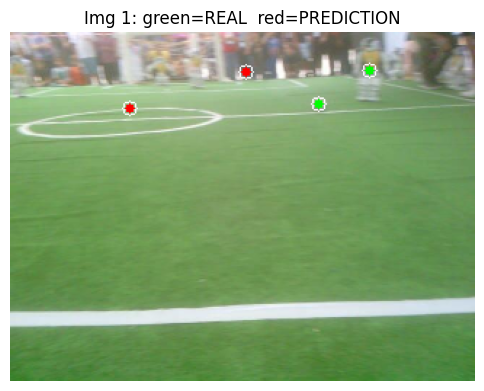


--- Analisi Centri Immagine 12 ---
Reale 1: (56, 21) px
Reale 2: (243, 50) px
Predetto 1: (92, 20) px
Predetto 2: (231, 47) px


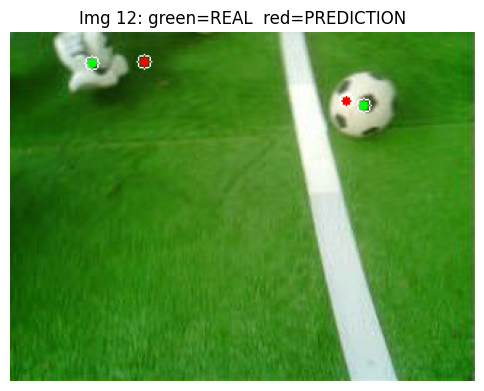


--- Analisi Centri Immagine 21 ---
Reale 1: (29, 182) px
Predetto 1: (37, 193) px


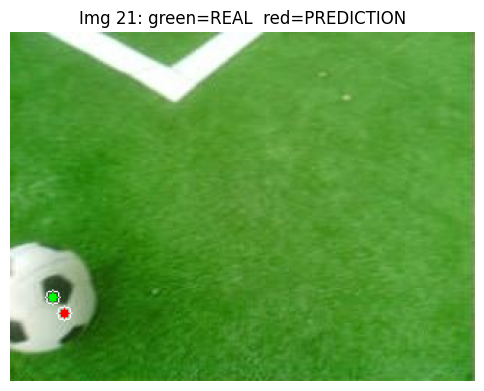


--- Analisi Centri Immagine 34 ---
Reale 1: (296, 107) px
Predetto 1: (278, 103) px


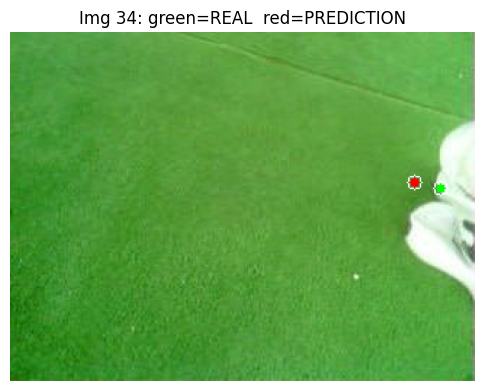


--- Analisi Centri Immagine 25 ---
Reale 1: (64, 39) px
Reale 2: (65, 63) px
Reale 3: (84, 28) px
Reale 4: (120, 33) px
Reale 5: (160, 26) px
Reale 6: (218, 42) px
Predetto 1: (56, 41) px
Predetto 2: (77, 79) px
Predetto 3: (100, 15) px
Predetto 4: (170, 24) px
Predetto 5: (181, 32) px
Predetto 6: (262, 35) px


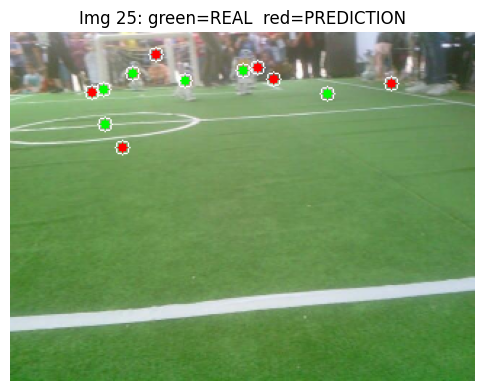


--- Analisi Centri Immagine 46 ---
Reale 1: (74, 148) px
Predetto 1: (107, 150) px


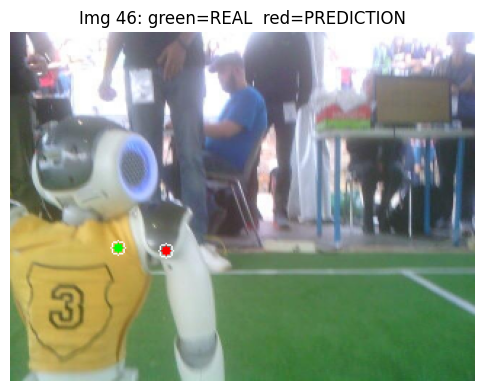


--- Analisi Centri Immagine 14 ---
Reale 1: (29, 52) px
Reale 2: (164, 22) px
Predetto 1: (25, 54) px
Predetto 2: (156, 31) px


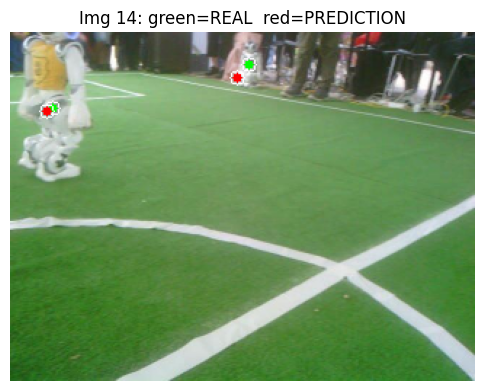


--- Analisi Centri Immagine 19 ---
Reale 1: (73, 178) px
Reale 2: (89, 186) px
Reale 3: (110, 188) px
Reale 4: (129, 180) px
Reale 5: (253, 229) px
Reale 6: (293, 197) px
Predetto 1: (46, 168) px
Predetto 2: (71, 174) px
Predetto 3: (91, 191) px
Predetto 4: (169, 163) px
Predetto 5: (209, 200) px
Predetto 6: (239, 183) px
Predetto 7: (3, 1) px


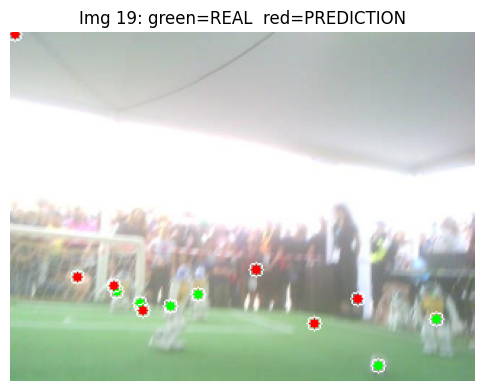


--- Analisi Centri Immagine 40 ---
Reale 1: (122, 66) px
Reale 2: (270, 49) px
Predetto 1: (86, 46) px
Predetto 2: (262, 56) px


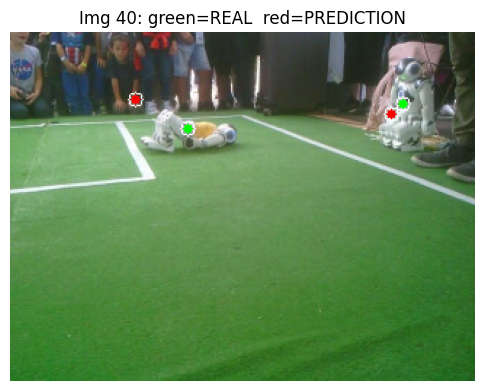


 ================== INIZIO CICLO CON SEED: 42 ================== 
ITERAZIONE 1 of 18
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 5, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 16, 'activation': 'relu', 'dropout': 0.0}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.1495 - mse: 0.0749 - val_loss: 0.1051 - val_mse: 0.0610
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1065 - mse: 0.0603 - val_loss: 0.1032 - val_mse: 0.0590
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0998 - mse: 0.0538 - val_loss: 0.0953 - val_mse: 0.0512
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0975 - mse: 0.0504 - val_loss: 0.0926 - val_mse: 0.0449
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0911 - mse: 0.0451 - val_loss: 0.0862 - val_mse: 0.0432
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0863 - mse: 0.0424 - val_loss: 0.0818 - val_mse: 0.0409
Epoch 7/120
88/88 ━━━━━━

KeyboardInterrupt: 

In [16]:
data,annotation=load_dataset()
x_train_img,x_train_class,y_train,x_test_img,x_test_class,y_test=dataset_modelling(data,annotation)
combination=create_hyperparam_combination()
total_combinations = len(combination)
x_train=[x_train_img,x_train_class]
x_test=[x_test_img,x_test_class]

final_results = []
for seed in SEEDS:
    print(f"\n ================== INIZIO CICLO CON SEED: {seed} ================== ")
    all_results = []
    bestmae=100000
    best_r2=-1000000
    current_seed_best_params = {}
    for i,param in enumerate(combination):
        print(f"ITERAZIONE {i+1} of {total_combinations}")
        print(f"PARAMETRI ATTUALI: {param}")     
        tf.keras.backend.clear_session()
        gc.collect()
        reset_seeds(seed)

        model=build_model( param['layer_number'],param['kernel_dim'],param['pool_dim'],param['fc1'],param['fc2'],param['activation'],param['class_out'],param['dropout'])

        opt=tf.keras.optimizers.Adam(learning_rate=param['lr'])

        model.compile(optimizer=opt,
                        loss='mae',
                        metrics=['mse'])
        
        early_stop=EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
            )
        
        reset_seeds(seed)
        history=model.fit(
                x_train,y_train,
                epochs=120,
                batch_size=param['batch_size'], 
                validation_split=0.2, 
                callbacks=[early_stop]
                )
        
        y_pred=model.predict(x_test)

        mae = mean_absolute_error(y_test, y_pred)
        r2=r2_score(y_test,y_pred)
        print("MAE:", mae)

        if mae<bestmae:
            bestmae=mae
            current_seed_best_params = param.copy()
            best_r2=r2
        save_csv(mae,param,seed,all_results,r2)

        print("\n--- ESEMPIO PREDIZIONE ---")
        idx = 80
        real_vals = y_test[idx]
        img_sample = x_test[0][idx:idx+1]   
        cls_sample = x_test[1][idx:idx+1]   

        pred_vals = model.predict([img_sample, cls_sample])[0]
        print(f"Reale (primi 4 valori): {real_vals[:4]}")
        print(f"Predetto (primi 4 valori): {pred_vals[:4]}")


    current_seed_best_params['seed'] = seed
    current_seed_best_params['best_mae_score'] = bestmae
    current_seed_best_params['best_r2_score'] = best_r2

    print(current_seed_best_params)
    visualize_only_centers(model, x_test, y_test,seed)
   

    final_results.append(current_seed_best_params)

df_best_results = pd.DataFrame(final_results)
df_best_results.to_csv('regression/csv/best_model/multiinput2_mae.csv', index=False)


